In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install pandarallel
!pip install datasketch
print("INSTALLATIONS COMPLETE.")

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=5b9d9e2026c0ab0567d4e771355ed979e663a75d3e5dba0ba5fda0156becdcad
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
  Obtaining dependency information for datasketch from https://files.pythonhosted.org/packages/81/71/fb0c28eff49fc0d725782f6dcf4ba2f71c52b6e6e9575179df3802b19d90/datasketch-1.6.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
INSTALLATIONS COMPLETE.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate, KFold, cross_val_score, StratifiedKFold , cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors, VALID_METRICS_SPARSE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy import sparse
from sklearn.preprocessing import normalize, binarize
from sklearn import random_projection
import time
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
from itertools import chain
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import torch

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    

print('Imports done.')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

# Question 3.1

In [3]:
train_df = pd.read_csv('/kaggle/input/bigdata2023duplicatedetection/train.csv')
test_df = pd.read_csv('/kaggle/input/bigdata2023duplicatedetection/test_without_labels.csv')

# train_df['Label_id'] = train_df['Label'].factorize()[0] # create specific ID for each label. Helps later on with wordclouds and XGBoost.

train_df.head()

,Id,Question1,Question2,IsDuplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test_df.head()

,Id,Question1,Question2
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?
2,283005,How can I make money online with free of cost?,How can I make money online for free?
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?


In [5]:
# check for NaN values
print("NaN (train) ?: \n",train_df.isnull().sum())
print("NaN (test) ?: \n", test_df.isnull().sum())

train_df['Question2'] = train_df['Question2'].fillna('')
test_df['Question1'] = test_df['Question1'].fillna('')
test_df['Question2'] = test_df['Question2'].fillna('')
# train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

for i,value in enumerate(train_df['Question2']):
    if type(value) == float:
        print(i)

print("NaN after cleanup (train) ?: \n",train_df.isnull().sum())
print("NaN after cleanup (test) ?: \n", test_df.isnull().sum())

NaN (train) ?: 
 Id             0
Question1      0
Question2      2
IsDuplicate    0
dtype: int64
NaN (test) ?: 
 Id           0
Question1    1
Question2    0
dtype: int64
NaN after cleanup (train) ?: 
 Id             0
Question1      0
Question2      0
IsDuplicate    0
dtype: int64
NaN after cleanup (test) ?: 
 Id           0
Question1    0
Question2    0
dtype: int64


## Data Preprocessing

In [6]:
# Text preprocessing for Content column
# Combine question 1 with question 2
stop = set(stopwords.words('english'))

train_df['Both_Questions'] = train_df['Question1'] + ' ' + train_df['Question2']
test_df['Both_Questions'] = test_df['Question1'] + ' ' + test_df['Question2']

# Lower all text

train_df['Both_Questions'] = train_df['Both_Questions'].str.lower()
test_df['Both_Questions'] = test_df['Both_Questions'].str.lower()

train_df['Question1'] = train_df['Question1'].str.lower()
train_df['Question2'] = train_df['Question2'].str.lower()

test_df['Question1'] = test_df['Question1'].str.lower()
test_df['Question2'] = test_df['Question2'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=8,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

train_df['Both_Questions'] = train_df['Both_Questions'].parallel_apply(remove_special_chars)
test_df['Both_Questions'] = test_df['Both_Questions'].parallel_apply(remove_special_chars)

train_df['Question1'] = train_df['Question1'].parallel_apply(remove_special_chars)
train_df['Question2'] = train_df['Question2'].parallel_apply(remove_special_chars)

test_df['Question1'] = test_df['Question1'].parallel_apply(remove_special_chars)
test_df['Question2'] = test_df['Question2'].parallel_apply(remove_special_chars)

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop]

train_df['Both_Questions'] = train_df['Both_Questions'].parallel_apply(remove_stopwords)
test_df['Both_Questions'] = test_df['Both_Questions'].parallel_apply(remove_stopwords)

train_df['Question1'] = train_df['Question1'].parallel_apply(remove_stopwords)
train_df['Question2'] = train_df['Question2'].parallel_apply(remove_stopwords)

test_df['Question1'] = test_df['Question1'].parallel_apply(remove_stopwords)
test_df['Question2'] = test_df['Question2'].parallel_apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

train_df['Both_Questions'] = train_df['Both_Questions'].parallel_apply(lemmatize_word)
test_df['Both_Questions'] = test_df['Both_Questions'].parallel_apply(lemmatize_word)

train_df['Question1'] = train_df['Question1'].parallel_apply(lemmatize_word)
train_df['Question2'] = train_df['Question2'].parallel_apply(lemmatize_word)

test_df['Question1'] = test_df['Question1'].parallel_apply(lemmatize_word)
test_df['Question2'] = test_df['Question2'].parallel_apply(lemmatize_word)

# pandarallel.initialize(nb_workers=8,progress_bar=True)



print('Example of preprocessing train: ')
print(train_df['Both_Questions'][0])
print("\n")
print('Example of preprocessing test: ')
print(test_df['Both_Questions'][0])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
step step guide invest share market india step step guide invest share market


Example of preprocessing test: 
someone lost wireless usb connector logitech keyboard mouse best usb wireless mouse used pc mac


In [7]:
hashing_vectorizer = HashingVectorizer()
X_train = hashing_vectorizer.fit_transform(train_df['Both_Questions'])
X_test = hashing_vectorizer.transform(test_df['Both_Questions'])

print('Preprocessing complete.')

Preprocessing complete.


## NN-Cosine

In [ ]:
# K = 10, Exact cosine algorithm
start_time = time.time()
nn =  NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine',n_jobs=-1).fit(X_train)
build_time = time.time() - start_time
print(f"Build time: {build_time} seconds")

start_time = time.time()
distances, indices = nn.kneighbors(X_test)
query_time = time.time() - start_time
print(f"Query time: {query_time} seconds")

flat_indices = indices.flatten()
print(len(flat_indices))

In [ ]:
# This code block calculates the number of duplicates for exact-cosine
flat_distances = distances.flatten()
filtered_distances = [value for value in flat_distances if value >= 0.8]
print(len(filtered_distances)) # this is the number of duplicates

## NN-Jaccard

In [ ]:
# turn hash-vectorized sparse matrices to SVD arrays in order to get faster computation.
# svd = TruncatedSVD(n_components=100)
# X_train_reduced = svd.fit_transform(X_train)
# X_test_reduced = svd.transform(X_test)
# spr = SparseRandomProjection(n_components=100)
# X_train_reduced = spr.fit_transform(X_train)
# X_test_reduced = spr.transform(X_test)
# scaler = StandardScaler(with_mean=False)
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=100)
# X_train_reduced_pca = pca.fit_transform(X_train_scaled)
# X_test_reduced_pca = pca.transform(X_train_scaled)

svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)


# Make SVD arrays to binary format for proper jaccard computation.
X_train_binary = binarize(X_train_reduced)
X_test_binary = binarize(X_test_reduced)

# 56600 -> 20% of train dataset
# 24257 -> 20% of test dataset

train_sample_size = 56600
test_sample_size = 24257

np.random.seed(42)

train_sample = np.random.choice(X_train_binary.shape[0], size=train_sample_size, replace=False)
test_sample = np.random.choice(X_test_binary.shape[0], size=test_sample_size, replace=False)

train_sampled_rows = X_train_binary[train_sample, :]
test_sampled_rows = X_test_binary[test_sample, :]

print(train_sampled_rows.shape)
print(test_sampled_rows.shape)
print('svd and binarization complete.')

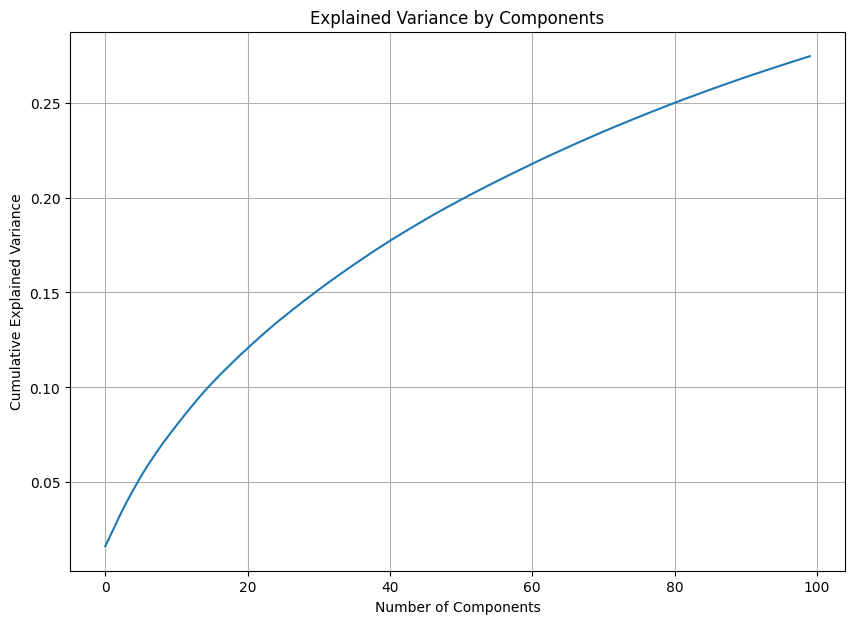

In [8]:
# Assume max_components is the maximum possible number of components
max_components = 100

# Fit the model
svd = TruncatedSVD(n_components=max_components)
X_train_reduced = svd.fit(X_train)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [ ]:
# K = 10, Exact jaccard algorithm

start_time = time.time()
nn =  NearestNeighbors(n_neighbors=10, algorithm='brute', metric='jaccard',n_jobs=-1).fit(train_sampled_rows)
build_time = time.time() - start_time
print(f"Build time: {build_time} seconds")


# Suppress DataConversionWarning for this block , to save some room
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DataConversionWarning)

    start_time = time.time()
    distances, indices = nn.kneighbors(test_sampled_rows)
    query_time = time.time() - start_time
    print(f"Query time: {query_time} seconds")

In [ ]:
# This code block calculates the number of duplicates for exact-jaccard
flat_distances = distances.flatten()
filtered_distances = [value for value in flat_distances if value >= 0.8]
print(len(filtered_distances) * 5) # this is the number of duplicates, with full dataset.

## Random projection experiments

In [ ]:
# n_components is the number of random hyperplanes
transformer = random_projection.GaussianRandomProjection(n_components=10)

X_new = transformer.fit_transform(X_train)
X_test_new = transformer.transform(X_test)

# X_new.shape

# X_new[0]

# Create the fingerprints
X_new = X_new > 0
X_test_new = X_test_new > 0

# Perform LSH
better_hash = []
for c in X_new:
    better_hash.append(sum([j*(2**i) for i,j in list(enumerate(reversed(c)))]))

better_test_hash = []
for c in X_test_new:
    better_test_hash.append(sum([j*(2**i) for i,j in list(enumerate(reversed(c)))]))

better_hash = np.array(better_hash)
better_test_hash = np.array(better_test_hash)

train_df['hash'] = better_hash
test_df['hash'] = better_test_hash


all_dist = []

# K = 10, testing with 10 neighbors first to save time
# For every unique hash create a specific instance of NN and get the flattened distances length
# which is essentially the number of duplicates
total_build_time = 0
total_query_time = 0

# unique_train_hashes = train_df['hash'].unique()
# unique_test_hashes = test_df['hash'].unique()

# for i, train_hash in enumerate(unique_train_hashes):
#     start_time = time.time()
#     bucket = X_train[train_df['hash'] == train_hash]
#     nn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine', n_jobs=-1).fit(bucket)
#     build_time = time.time() - start_time
#     total_build_time += build_time

#     start_time = time.time()
#     test_buckets = [X_test[test_df['hash'] == test_hash] for test_hash in unique_test_hashes]

#     # Stack sparse test buckets using scipy's vstack
#     test_array = sp.vstack(test_buckets)
    
#     distances, indices = nn.kneighbors(test_array)
#     query_time = time.time() - start_time
#     total_query_time += query_time

#     # Separate the distances for each test hash
#     dist_split = np.split(distances, np.cumsum([test_bucket.shape[0] for test_bucket in test_buckets])[:-1])
#     all_dists.extend(dist_split)
# // 550 jic

train_nn_models = {}

# print(train_df.shape)
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=10): {total_build_time} seconds")
print(f"Query time (K=10): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 1
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape) // 30
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=1): {total_build_time} seconds")
print(f"Query time (K=1): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 2
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape) // 100
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=2, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=2): {total_build_time} seconds")
print(f"Query time (K=2): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 3
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape) // 100
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=3, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=3): {total_build_time} seconds")
print(f"Query time (K=3): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 4
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape)  // 300
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=4, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=4): {total_build_time} seconds")
print(f"Query time (K=4): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 5
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape)  // 400
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=5): {total_build_time} seconds")
print(f"Query time (K=5): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 6
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape)  // 400
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=6): {total_build_time} seconds")
print(f"Query time (K=6): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 7
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape) // 400
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=7, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=7): {total_build_time} seconds")
print(f"Query time (K=7): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 8
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape) // 450
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=8, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=8): {total_build_time} seconds")
print(f"Query time (K=8): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

In [ ]:
# K = 9
all_dist = []
total_build_time = 0
total_query_time = 0
train_nn_models = {}

# print(train_df.shape),  // 250
for i in range(train_df['hash'].nunique()):
    start_time = time.time()
    hash = train_df['hash'].unique()[i]
    bucket = X_train[train_df['hash']==hash]
    nn =  NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine',n_jobs=-1).fit(bucket)
    train_nn_models[hash] = nn
    build_time = time.time() - start_time
    total_build_time += build_time

    
for i in range(test_df['hash'].nunique()):
    start_time = time.time()
    test_hash = test_df['hash'].unique()[i]
    test_bucket = X_test[test_df['hash']==test_hash]
    if test_hash in train_nn_models:
        trained_nn = train_nn_models[test_hash]
    
    distances, indices = trained_nn.kneighbors(test_bucket)
    query_time = time.time() - start_time
    total_query_time += query_time
    all_dist.append(distances)
    


print(f"Build time (K=9): {total_build_time} seconds")
print(f"Query time (K=9): {total_query_time} seconds")

flattened_all_dist = [item for sublist in all_dist for item in sublist]
flat_distances_array = [item for sublist in flattened_all_dist for item in sublist]
filtered_distances = [value for value in flat_distances_array if value >= 0.8]
print("duplicate number: ", len(filtered_distances))

## MinHash experiments

In [ ]:
# Tokenize and create sets of tokens

pandarallel.initialize(nb_workers=8,progress_bar=True)

def tokenize_text(text):
    return set(word_tokenize(text))

# Tokenize and create sets of tokens for test_df and train_df
train_df['Tokenized'] = train_df['Both_Questions'].parallel_apply(lambda x: tokenize_text(x))
test_df['Tokenized'] = test_df['Both_Questions'].parallel_apply(lambda x: tokenize_text(x))

# Now train_df['Tokenized'] contains sets of tokens for each article
print(train_df['Tokenized'][0])

In [ ]:
# Min Hash LSH

from datasketch import MinHash, MinHashLSH

minhash_objects = []

def create_minhash(tokens):
    minhash = MinHash(num_perm=16)
    for token in tokens:
        minhash.update(token.encode('utf8'))
    return minhash
    

start_time = time.time()


minhash_objects = list(map(create_minhash, train_df['Tokenized']))


# Create MinHashLSH Index, // 150
lsh = MinHashLSH(threshold=0.8, num_perm=16)

for i, minhash in enumerate(minhash_objects):
    lsh.insert(i, minhash)
    
build_time = time.time() - start_time
print(f"Build time (minhash lsh with 16 permutations, threshold >= 0.8): {build_time} seconds")
start_time = time.time()
test_minhash_objects = []
# Create MinHash objects for test_df
test_minhash_objects = list(map(create_minhash, test_df['Tokenized']))

test_candidates = [lsh.query(minhash) for minhash in test_minhash_objects]

query_time = time.time() - start_time
print(f"Query time (minhash lsh with 16 permutations, threshold >= 0.8): {query_time} seconds")
print('min hash done.')
test_candidates_flat = [item for sublist in test_candidates for item in sublist]
print("# of duplicates: ",len(test_candidates_flat))

In [ ]:
# 32 permutations minhash LSH
minhash_objects_32 = []

def create_minhash(tokens):
    minhash = MinHash(num_perm=32)
    for token in tokens:
        minhash.update(token.encode('utf8'))
    return minhash

start_time = time.time()
minhash_objects_32 = list(map(create_minhash, train_df['Tokenized']))

# Create MinHashLSH Index,  // 150
lsh2 = MinHashLSH(threshold=0.8, num_perm=32)

for i, minhash in enumerate(minhash_objects_32):
    lsh2.insert(i, minhash)

build_time = time.time() - start_time
print(f"Build time (lsh with 32 permutations, threshold >= 0.8): {build_time} seconds")


start_time = time.time()
# Create MinHash objects for test_df
test_minhash_objects_32 = list(map(create_minhash, test_df['Tokenized']))

# Query MinHashLSH for candidates in train_df
test_candidates_32 = [lsh2.query(minhash) for minhash in test_minhash_objects_32]

query_time = time.time() - start_time
print(f"Query time (lsh with 32 permutations, threshold >= 0.8): {query_time} seconds")
test_candidates_flat_32 = [item for sublist in test_candidates_32 for item in sublist]
print("# of duplicates: ",len(test_candidates_flat_32))

In [ ]:
# 64 permutations minhash LSH
minhash_objects_64 = []

def create_minhash(tokens):
    minhash = MinHash(num_perm=64)
    for token in tokens:
        minhash.update(token.encode('utf8'))
    return minhash

start_time = time.time()

minhash_objects_64 = list(map(create_minhash, train_df['Tokenized']))

# Create MinHashLSH Index,  // 150
lsh3 = MinHashLSH(threshold=0.8, num_perm=64)

for i, minhash in enumerate(minhash_objects_64):
    lsh3.insert(i, minhash)

build_time = time.time() - start_time
print(f"Build time (lsh with 64 permutations, threshold >= 0.8): {build_time} seconds")

start_time = time.time()
# Create MinHash objects for test_df
test_minhash_objects_64 = list(map(create_minhash, test_df['Tokenized']))

# Query MinHashLSH for candidates in train_df
test_candidates_64 = [lsh3.query(minhash) for minhash in test_minhash_objects_64]

query_time = time.time() - start_time
print(f"Query time (lsh with 64 permutations, threshold >= 0.8): {query_time} seconds")
test_candidates_flat_64 = [item for sublist in test_candidates_64 for item in sublist]
print("# of duplicates: ",len(test_candidates_flat_64))

# Question 3.2 (Extra)

## Initial model training and evaluation

In [ ]:
y_train = train_df['IsDuplicate']

# SVM test
svm_model = LinearSVC(random_state = 42, max_iter=1000)

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(svm_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== SVM Classification Report ======================")
print("\n")
print(classification_report(y_train, y_pred))

In [ ]:
# Logistic Regression test
lr_model = LogisticRegression(tol=1e-4, C=1.0, n_jobs=-1, solver='sag',random_state=42)

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(lr_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== Logistic Regression Classification Report ======================")
print("\n")
print(classification_report(y_train, y_pred))

## Feature engineering

In [8]:
# Feature engineering

# Get question lengths
train_df['q1_len'] = train_df['Question1'].str.len() 
train_df['q2_len'] = train_df['Question2'].str.len()

# Get number of words in each question
train_df['q1_num_words'] = train_df['Question1'].apply(lambda row: len(row.split(" ")))
train_df['q2_num_words'] = train_df['Question2'].apply(lambda row: len(row.split(" ")))

# Get common words of each row
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['Question2'].split(" ")))    
    return len(w1 & w2)

train_df['word_common'] = train_df.apply(common_words, axis=1)

# Get total words of each row
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['Question2'].split(" ")))    
    return (len(w1) + len(w2))

train_df['word_total'] = train_df.apply(total_words, axis=1)

# Find shared words in each row
train_df['word_share'] = round(train_df['word_common']/train_df['word_total'],2)

train_df.head()

,Id,Question1,Question2,IsDuplicate,Both_Questions,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,step step guide invest share market india,step step guide invest share market,0,step step guide invest share market india step...,41,35,7,6,5,11,0.45
1,1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,story kohinoor koh noor diamond would happen i...,31,67,5,10,4,15,0.27
2,2,increase speed internet connection using vpn,internet speed increased hacking dns,0,increase speed internet connection using vpn i...,44,36,6,5,2,11,0.18
3,3,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,mentally lonely solve find remainder math 23 2...,21,44,3,9,0,9,0.00
4,4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,one dissolve water quikly sugar salt methane c...,60,29,10,5,2,15,0.13


minimum characters 0
maximum characters 328
average num of characters 36


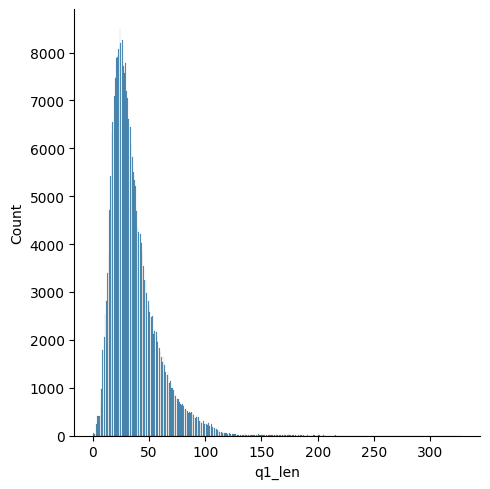

In [12]:
# Small visualization to get a grasp of the length of the questions
sns.displot(train_df['q1_len'])
print('minimum characters',train_df['q1_len'].min())
print('maximum characters',train_df['q1_len'].max())
print('average num of characters',int(train_df['q1_len'].mean()))

minimum characters 0
maximum characters 647
average num of characters 36


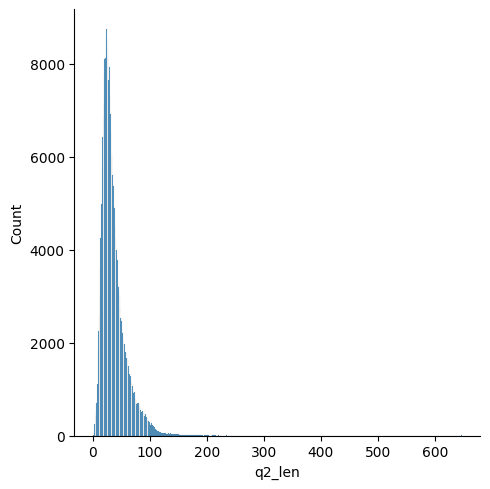

In [13]:
sns.displot(train_df['q2_len'])
print('minimum characters',train_df['q2_len'].min())
print('maximum characters',train_df['q2_len'].max())
print('average num of characters',int(train_df['q2_len'].mean()))

In [ ]:
X_train_feature_eng = train_df[['q1_len','q2_len','q1_num_words','q2_num_words','word_common','word_total','word_share']]
y_train_feat_eng = train_df['IsDuplicate']

# SVM feature_eng
svm_model = LinearSVC(random_state = 42, max_iter=1000)

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(svm_model, X_train_feature_eng, y_train_feat_eng, cv=5)

# Print classification report for each category
print("====================== SVM Classification Report ======================")
print("\n")
print(classification_report(y_train_feat_eng, y_pred))

In [ ]:
# Logistic Regression test
lr_model = LogisticRegression(tol=1e-4, C=1.0, n_jobs=-1, solver='sag',random_state=42)

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(lr_model, X_train_feature_eng, y_train_feat_eng, cv=5)

# Print classification report for each category
print("====================== Logistic Regression Classification Report ======================")
print("\n")
print(classification_report(y_train_feat_eng, y_pred))

In [ ]:
# Random forest test
rf_model = RandomForestClassifier()

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(rf_model, X_train_feature_eng, y_train_feat_eng, cv=5)

# Print classification report for each category
print("====================== Random Forest Classification Report ======================")
print("\n")
print(classification_report(y_train_feat_eng, y_pred))

## Obtain predictions

In [ ]:
svm_model.fit(X_train,y_train)

y_pred_test = svm_model.predict(X_test)

print('Training complete.')

## Output file

In [ ]:
import csv

with open('duplicate_predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(len(test_df)):
        writer.writerow([test_df['Id'][i],y_pred_test[i]])  
    
    
print("CSV file writing complete.")